# CPSC320: Program 6 - Wasserstein Generative Adversarial Network (WGAN_GP) on Flower Dataset (Run on Google Colab)
In this programming assignment, you will build a GAN_GP for generating flower images.

**Important**: The notebook you will submit must be the one you have RUN all the cells (DO NOT CLEAR OUTPUTS OF ALL CELLS).

**Hints**: You may refere to the scripts of *10_4_wgan_gp_mnist.ipynb* and *10_5_WGAN_GP_CeleA_Faces.ipynb* to get most of he code from there. You need to make some adjustments wherever necessary.

In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, metrics, losses
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# check whether GPU is avaiable to use
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

Num GPUs Available:  1
Thu Nov 28 14:32:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## 1. Dataset Preparation

**Note**:
- The setup for this section should be very similar to the section 1 of the previous program.
- If you have your own machine with gpu installed, you may modify your scripts in Section 1 as you did in program 5.

### 1.1 Upload Dataset to Google Colab

In [3]:
# mount to your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

#WARNING: YOU MUST CHANGE THE ZIP PATH SO IT READS THE ZIPPED DATASET FROM YOUR GOOGLE DRIVE#

zip_path = '/content/drive/MyDrive/data/flowers_train_validation.zip'  # Change this to your zip path
extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


In [5]:
IMAGE_SIZE = 64
CHANNELS = 3
NUM_FEATURES = 128
Z_DIM = 50
BATCH_SIZE = 128
input_shape = (64,64, 3)
BETA = 1
latent_dim = 50
codings_size = 50
img_shape = (64,64, 3)

### 1.2: Data Preprocessing

#### 1.2.1 Using image_dataset_from_directory for constructing training dataset

**Task 1: Read image_dataset_from_directory**:

Do the followings:
- Provide your train dateset directory unzipped from Section 1.1.
- Set your image_size to be (64, 64).
- Set your batch_size to be 128.
- Modify other arguments if necessary.

In [6]:
# Load the train data
# We only use training dataset to build our VAE model
train_dataset = "./flowers_train_validation/train"
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dataset,  # this is the train dataset folder on your google colab
    color_mode= "rgb",
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

print(type(train_data))

Found 3456 files.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 1.2.2 Preprocessing images

**Task 2: Preprocessing image**

Preprocess the imput image so that it is normalized into the value between (-1, 1) *i.e.*, the original pixel value should be subtracted from 127.5 and then divided by 127.5, and then return the normalized image back.

**Why?** Because the last layer of generator in our GAN_GP model has the activation of *tanh*. We need to be consistent for both faked images and real images when they are fed into our critic model.

In [7]:
# Preprocess the data below
def preprocess(img):
    return (tf.cast(img, tf.float32) - 127.5) / 127.5

In [8]:
# the training dataset has been processed for model training
train_data = train_data.map(lambda x: preprocess(x))

### 1.3 Checking train data

**Note**: If all the above steps are set correctly, you should be able  to see the images read frm training data.

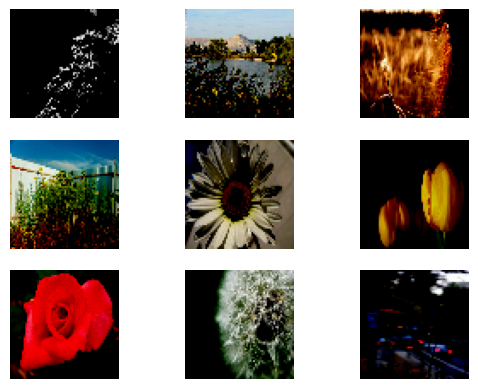

In [9]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for batch in train_data.take(1):
    # Iterate through images in the batch
    for i in range(9):  # Show 9 images for preview
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy().clip(0, 1))  # Clip values to [0, 1] range
        plt.axis('off')
    plt.show()


## 2. Define the WGAN_GP Model

### 2.1 The Generator

**Task 3: Generator**:

Define your generator **on your own choices**, but you may follow the common strategies:

- **The Generator Architecture**.  The Generator Architecture is very similar to decoder in VAE, that is, using transposed convolutional layers (Conv2DTranspose).
- **Activation Functions**. The final layer should use an activation function that matches the data characteristics, i.e., *tanh* for pixel values in the range [-1, 1]. Intermediate layers can use ReLU or LeakyReLU.
- **Final Output Layer**: In general, you should have the same number of channels and spatial dimensions as the original input image i.e., **(64, 64 ,3)**. So you need cropping or padding if necessary.
- Suggested input Latent Space **dimension = 50** (don't make it too big as our training set size is only about 3000 vs celeb dataset size = 200,000
- print out the generator model summary

**Note**: You may refer to the generator model in *10_5_WGAN_GP_CeleA_Faces.ipynb*

In [10]:
# Define the Generator below

# Generator
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()
# generator = None




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,169,027 (12.09 MB)

 Trainable params: 3,167,107 (12.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 2.2 The Critic

**Task 4: Critic**:

Define your critic **on your own choices**, but you may follow the common strategies:

- **Fully Convolutional Design**: The critic uses convolutional layers to downsample the image gradually.
- **Final Output Layer**: The last layer should only have one node, and we don't have an activation layer since we are implementing WGAN, not GAN.
- **Leaky ReLU Activation**: Helps with gradient flow for low-activation inputs.
- **Gradient Penalty**: Regularizes the critic’s gradient by addding gradient penalty to improve convergence.
- Print out your critic's model summary.

**Note**: You may refer to the generator model in *10_5_WGAN_GP_CeleA_Faces.ipynb*

In [11]:
# Define the Critic
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,193 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,764,737 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 WGAN_GP

**Task 5: WGAN_GP**:

You will define the WGAN_GP model class  inherits *model.Model*. You may copy most of  WGAN_GP model implemenation from *10_5_WGAN_GP_CeleA_Faces.ipynb*, but you need to understand how the following methods are implemented:
- *wasserstein_loss*: Measures the Wasserstein distance between real and fake data distributions to guide training.
- *gradient_penalty*: Regularizes the critic's gradients to enforce Lipschitz continuity for stable training.
- *train_step*: Alternates between updating the critic (multiple steps) and generator (single step) to improve both models.

In addition, be consistent with your default parameters, such as:
- Input Latent Space **dimension = 50**
- Batch size = 128


In [12]:
# Define the WGAN_GP model below

class WGAN_GP(Model):
    def __init__(self, generator, critic, clip_value=0.01,
                 n_critic=5, latent_dim=latent_dim, batch_size=BATCH_SIZE):
        super(WGAN_GP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.clip_value = clip_value
        self.n_critic = n_critic
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.generator_optimizer = RMSprop(learning_rate=0.00005)
        self.critic_optimizer = RMSprop(learning_rate=0.00005)

    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    def compile(self, **kwargs):
        super(WGAN_GP, self).compile(**kwargs)

    def train_step(self, real_imgs):
        batch_size = tf.shape(real_imgs)[0]
        real_labels = -tf.ones((batch_size, 1))
        fake_labels = tf.ones((batch_size, 1))

        for _ in range(self.n_critic):
            with tf.GradientTape() as critic_tape:
                noise = tf.random.normal((batch_size, self.latent_dim))
                fake_imgs = self.generator(noise)

                real_loss = self.wasserstein_loss(real_labels, self.critic(real_imgs))
                fake_loss = self.wasserstein_loss(fake_labels, self.critic(fake_imgs))

                gp = self.gradient_penalty(real_imgs, fake_imgs)
                d_loss = 0.5 * (real_loss + fake_loss) + 5.0 * gp  # Lambda for GP

            critic_grads = critic_tape.gradient(d_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        with tf.GradientTape() as gen_tape:
            noise = tf.random.normal((batch_size, self.latent_dim))
            fake_imgs = self.generator(noise)
            g_loss = self.wasserstein_loss(real_labels, self.critic(fake_imgs))

        gen_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}
        # batch_size = tf.shape(real_imgs)[0]
        # real_labels = -tf.ones((batch_size, 1))
        # fake_labels = tf.ones((batch_size, 1))

        # for _ in range(self.n_critic):
        #     with tf.GradientTape() as critic_tape:
        #         noise = tf.random.normal((batch_size, self.latent_dim))
        #         fake_imgs = self.generator(noise)

        #         # calculate critic loss on real & fake images
        #         real_loss = self.wasserstein_loss(real_labels, self.critic(real_imgs))
        #         fake_loss = self.wasserstein_loss(fake_labels, self.critic(fake_imgs))

        #         d_loss = 0.5 * (real_loss + fake_loss)

        #     # update critic weights
        #     critic_grads = critic_tape.gradient(d_loss, self.critic.trainable_variables)
        #     self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

        # for layer in self.critic.layers:
        #   weights = layer.get_weights()
        #   weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
        #   layer.set_weights(weights)


        # with tf.GradientTape() as gen_tape:
        #   noise = tf.random.normal((batch_size, self.latent_dim))
        #   fake_imgs = self.generator(noise)
        #   g_loss = self.wasserstein_loss(real_labels, self.critic(fake_imgs))

        # gen_grads = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        # self.generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))

        # return {"d_loss": d_loss, "g_loss": g_loss}



    def gradient_penalty(self, real_imgs, fake_imgs):
        alpha = tf.random.uniform([self.batch_size, 1, 1, 1], 0., 1.)
        interpolated = alpha * real_imgs + (1 - alpha) * fake_imgs

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            interpolated_score = self.critic(interpolated)

        grads = gp_tape.gradient(interpolated_score, [interpolated])[0]
        grad_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        return tf.reduce_mean((grad_l2 - 1.0) ** 2)


In [13]:
# Initialize and compile WGAN
wgan_gp = WGAN_GP(generator=generator, critic=critic)
wgan_gp.compile()

## 3. Model training

In [14]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.clip(image, 0, 1))
        plt.axis("off")

**Task 6: Train the wgan_gp model and generate the faked images**:

You may refer from *10_4_wgan_gp_mnist.ipynb* to see how to train the model. After each epoch, you will also generate 128 faked images and then do ploting using *plot_results* method implemented above.

**Important**:
- It is computing intensive so the final results may not look good enough if epochs number is small
- Suggested epochs = 100 for google colab
- You may try large epochs such as 500 if you have GPUs installed on your local machine.

In [15]:
# training your wgan_gp model and display 128 faked images
n_epochs = 100

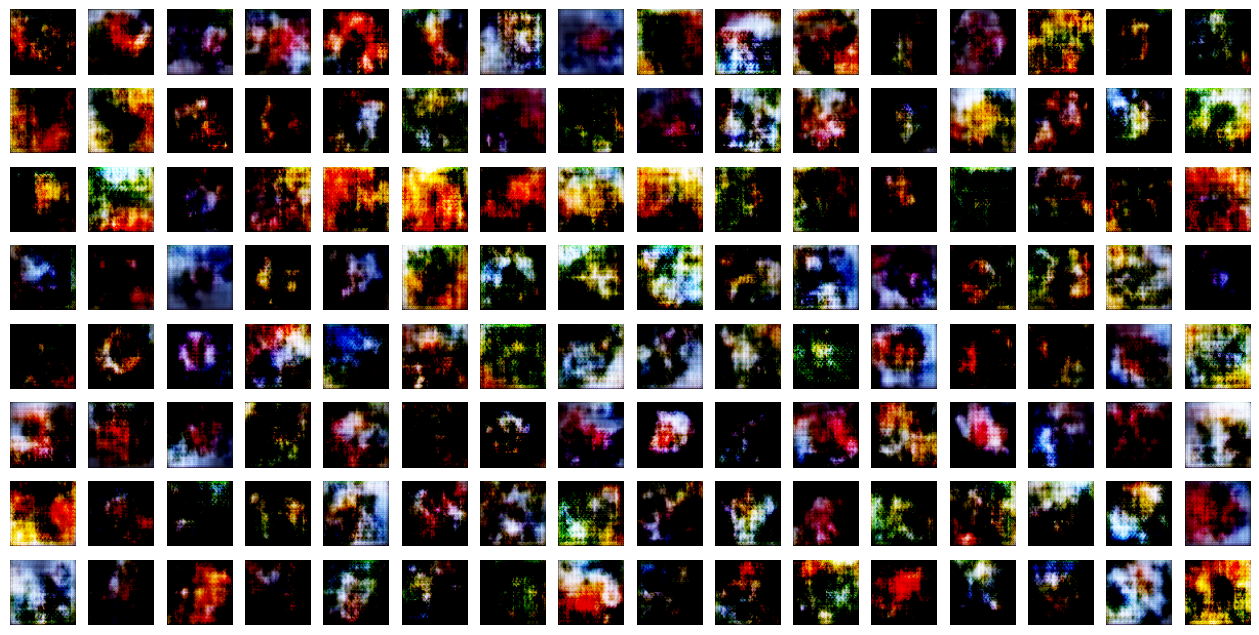

In [16]:
for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for real_images in train_data:
        wgan_gp.train_step(real_images)

    # generate fake images
    noise = tf.random.normal((128, latent_dim))
    fake_imgs = wgan_gp.generator(noise)

    # plot the fake images used to train the discriminator
    plot_results(fake_imgs, 16)
    plt.show()
